#### Sentinel data

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import ee
import geemap
# import folium

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()


def get_scl_milano(start_date, end_date):
    # Define Milano area
    milano = ee.Geometry.Rectangle([
        9.05, 45.35,  # Lower left
        9.35, 45.55   # Upper right
    ])

    # Get Sentinel-2 collection
    s2_scl = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(milano) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .select('SCL')

    # Get median composite
    scl_composite = s2_scl.mode()  # Using mode for categorical data

    return scl_composite, milano

def visualize_scl(scl_image, aoi):
    """
    Create visualization for SCL
    """
    # Define visualization parameters
    scl_viz = {
        'min': 0,
        'max': 11,
        'palette': [
            '#000000',  # NO_DATA
            '#ff0000',  # SATURATED_OR_DEFECTIVE
            '#4c4c4c',  # DARK_AREA_PIXELS
            '#666666',  # CLOUD_SHADOWS
            '#00ff00',  # VEGETATION
            '#ffff00',  # NOT_VEGETATED
            '#0000ff',  # WATER
            '#dddddd',  # UNCLASSIFIED
            '#cccccc',  # CLOUD_MEDIUM_PROBABILITY
            '#ffffff',  # CLOUD_HIGH_PROBABILITY
            '#88ffff',  # THIN_CIRRUS
            '#ff88ff'   # SNOW
        ]
    }

    # Create the map
    Map = geemap.Map(center=[45.46, 9.19], zoom=11)
    Map.addLayer(scl_image, scl_viz, 'Scene Classification')
    Map.add_legend(
        title='Scene Classification',
        labels=[
            'NO_DATA', 'SATURATED', 'DARK_PIXELS', 'CLOUD_SHADOWS',
            'VEGETATION', 'NOT_VEGETATED', 'WATER', 'UNCLASSIFIED',
            'CLOUD_MEDIUM', 'CLOUD_HIGH', 'THIN_CIRRUS', 'SNOW'
        ],
        colors=scl_viz['palette']
    )

    return Map




Successfully saved authorization token.


In [5]:
# Define time period
start_date = '2024-12-01'
end_date = '2024-12-30'

# Get SCL data
scl_image, milano_aoi = get_scl_milano(start_date, end_date)

# Visualize
Map = visualize_scl(scl_image, milano_aoi)
Map

print(scl_image.getInfo())
print(milano_aoi.getInfo())

/home/whm36/.local/lib/python3.10/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


{'type': 'Image', 'bands': [{'id': 'SCL', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
{'type': 'Polygon', 'coordinates': [[[9.05, 45.35], [9.35, 45.35], [9.35, 45.55], [9.05, 45.55], [9.05, 45.35]]]}


In [6]:
# Save SCL to current directory
geemap.ee_export_image(scl_image, filename='scl_milano.tif', scale=20, region=milano_aoi)


Generating URL ...
Please wait ...
Data downloaded to /home/whm36/WHM/Copernicus/scl_milano.tif


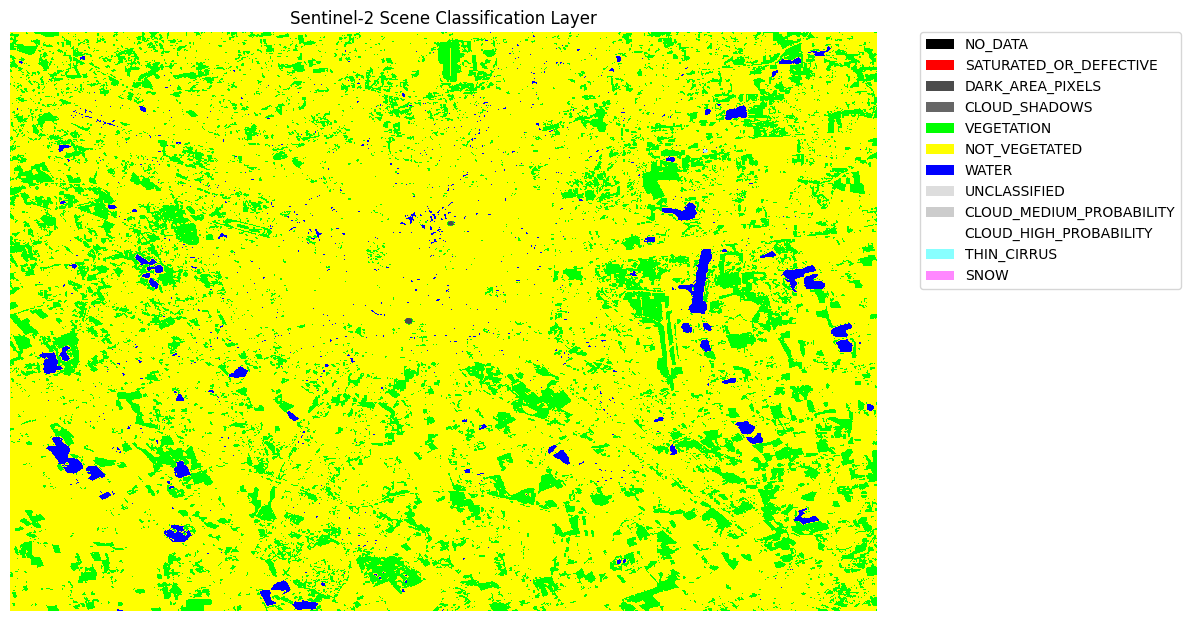


Class Statistics:
--------------------------------------------------
Class                          Pixels     Percentage
--------------------------------------------------
NO_DATA                        0                0.00%
SATURATED_OR_DEFECTIVE         0                0.00%
DARK_AREA_PIXELS               227              0.01%
CLOUD_SHADOWS                  0                0.00%
VEGETATION                     315245          16.93%
NOT_VEGETATED                  1506810         80.92%
WATER                          39721            2.13%
UNCLASSIFIED                   0                0.00%
CLOUD_MEDIUM_PROBABILITY       0                0.00%
CLOUD_HIGH_PROBABILITY         0                0.00%
THIN_CIRRUS                    47               0.00%
SNOW                           0                0.00%


In [7]:
# Plot the SCL TIF file
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_scl_tif(tif_path):
    """
    Plot SCL TIF file with proper colors and legend
    """
    # Read the TIF file
    with rasterio.open(tif_path) as src:
        scl_data = src.read(1)

    # Define colors for each class (matching GEE visualization)
    colors = {
        0: '#000000',  # NO_DATA
        1: '#ff0000',  # SATURATED_OR_DEFECTIVE
        2: '#4c4c4c',  # DARK_AREA_PIXELS
        3: '#666666',  # CLOUD_SHADOWS
        4: '#00ff00',  # VEGETATION
        5: '#ffff00',  # NOT_VEGETATED
        6: '#0000ff',  # WATER
        7: '#dddddd',  # UNCLASSIFIED
        8: '#cccccc',  # CLOUD_MEDIUM_PROBABILITY
        9: '#ffffff',  # CLOUD_HIGH_PROBABILITY
        10: '#88ffff', # THIN_CIRRUS
        11: '#ff88ff'  # SNOW
    }

    # Create custom colormap
    color_list = [colors[i] for i in range(12)]
    custom_cmap = ListedColormap(color_list)

    # Create figure and plot
    plt.figure(figsize=(12, 8))

    # Plot the image
    img = plt.imshow(scl_data, cmap=custom_cmap, vmin=0, vmax=11)

    # Add legend
    legend_labels = [
        'NO_DATA',
        'SATURATED_OR_DEFECTIVE',
        'DARK_AREA_PIXELS',
        'CLOUD_SHADOWS',
        'VEGETATION',
        'NOT_VEGETATED',
        'WATER',
        'UNCLASSIFIED',
        'CLOUD_MEDIUM_PROBABILITY',
        'CLOUD_HIGH_PROBABILITY',
        'THIN_CIRRUS',
        'SNOW'
    ]

    legend_elements = [Patch(facecolor=colors[i],
                           label=legend_labels[i])
                      for i in range(12)]

    plt.legend(handles=legend_elements,
              bbox_to_anchor=(1.05, 1),
              loc='upper left',
              borderaxespad=0.)

    plt.title('Sentinel-2 Scene Classification Layer')
    plt.axis('off')
    plt.tight_layout()

    return plt

def print_class_statistics(tif_path):
    """
    Print statistics about each class in the SCL image
    """
    with rasterio.open(tif_path) as src:
        scl_data = src.read(1)

    classes = {
        0: 'NO_DATA',
        1: 'SATURATED_OR_DEFECTIVE',
        2: 'DARK_AREA_PIXELS',
        3: 'CLOUD_SHADOWS',
        4: 'VEGETATION',
        5: 'NOT_VEGETATED',
        6: 'WATER',
        7: 'UNCLASSIFIED',
        8: 'CLOUD_MEDIUM_PROBABILITY',
        9: 'CLOUD_HIGH_PROBABILITY',
        10: 'THIN_CIRRUS',
        11: 'SNOW'
    }

    total_pixels = scl_data.size
    print("\nClass Statistics:")
    print("-" * 50)
    print(f"{'Class':<30} {'Pixels':<10} {'Percentage':>10}")
    print("-" * 50)

    for class_value, class_name in classes.items():
        pixel_count = np.sum(scl_data == class_value)
        percentage = (pixel_count / total_pixels) * 100
        print(f"{class_name:<30} {pixel_count:<10} {percentage:>10.2f}%")

plot = plot_scl_tif('scl_milano.tif')
plot.show()

print_class_statistics('scl_milano.tif')


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1670, 'height': 1115, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0001796630568239043, 0.0, 9.049987498333707,
       0.0, -0.0001796630568239043, 45.55015445962128), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
(200, 200)

Class Statistics:
--------------------------------------------------
Class                          Pixels     Percentage
--------------------------------------------------
NO_DATA                        0                0.00%
SATURATED_OR_DEFECTIVE         0                0.00%
DARK_AREA_PIXELS               0                0.00%
CLOUD_SHA

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.



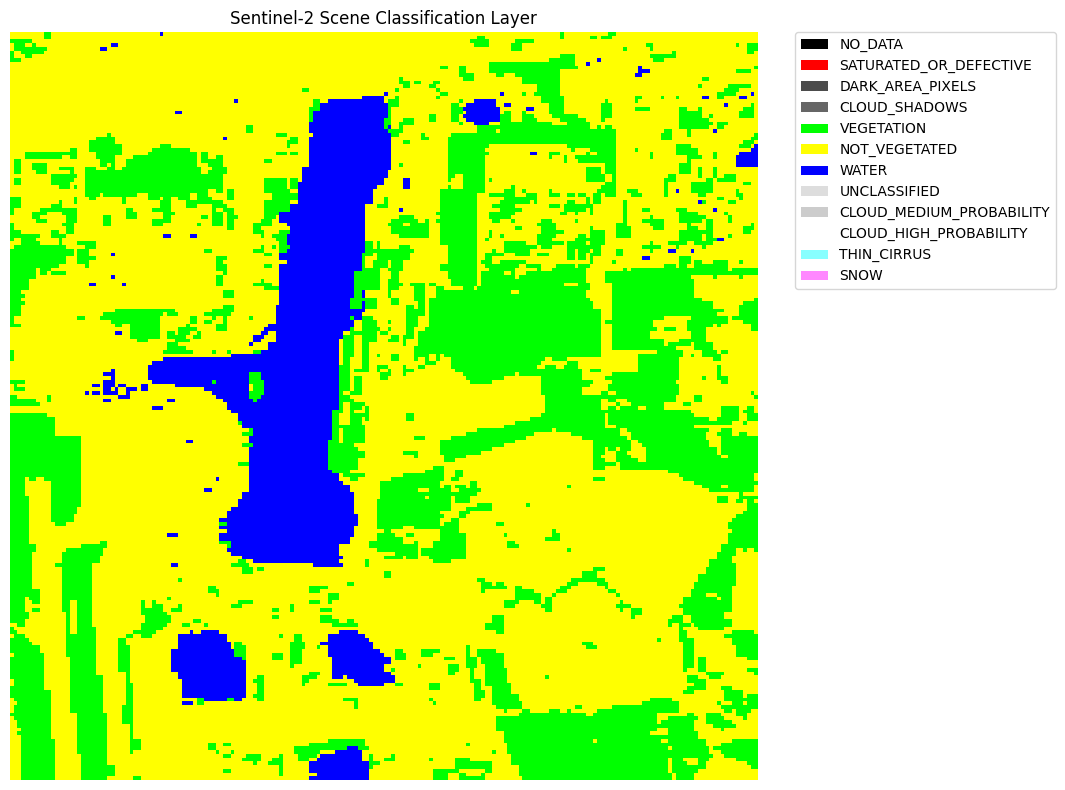

In [41]:
# Clip smaller Milano SCL image for somulation
with rasterio.open('scl_milano.tif') as src:
    scl_milano_array = src.read(1)  # (1115, 1670)
    print(src.profile)

scl_clip = scl_milano_array[400:600, 1250:1450]  # shape: (200, 200)
print(scl_clip.shape)

# Save the clipped SCL image
profile = src.profile.copy()
profile.update(width=200, height=200, transform=src.transform)
with rasterio.open('scl_milano_clip.tif', 'w', **profile) as dst:
    dst.write(scl_clip, 1)

# Plot the clipped SCL image
plot = plot_scl_tif('scl_milano_clip.tif')

print_class_statistics('scl_milano_clip.tif')

In [42]:
# Assign Manning's n for each SCL class
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

def assign_mannings_n(scl_path, output_path):
    manning_values = {
        0: 0.0,    # NO_DATA
        1: 0.0,    # SATURATED_OR_DEFECTIVE
        2: 0.03,   # DARK_AREA_PIXELS (assumed bare soil)
        3: 0.0,    # CLOUD_SHADOWS
        4: 0.1,    # VEGETATION (forest/dense vegetation)
        5: 0.03,   # NOT_VEGETATED (bare soil/urban)
        6: 0.025,  # WATER
        7: 0.03,   # UNCLASSIFIED (assumed bare soil)
        8: 0.0,    # CLOUD_MEDIUM_PROBABILITY
        9: 0.0,    # CLOUD_HIGH_PROBABILITY
        10: 0.0,   # THIN_CIRRUS
        11: 0.01   # SNOW
    }

    with rasterio.open(scl_path) as src:
        scl_data = src.read(1)
        profile = src.profile

        # Create Manning's n array
        manning_array = np.zeros_like(scl_data, dtype=np.float32)

        # Assign values
        for scl_class, n_value in manning_values.items():
            manning_array[scl_data == scl_class] = n_value

        # Update profile for floating point data
        profile.update(
            dtype=rasterio.float32,
            nodata=0.0
        )

        # Save Manning's n raster
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(manning_array.astype(rasterio.float32), 1)

    return manning_array

def plot_mannings(manning_array):
    # Create custom colormap
    colors = ['#4575b4', '#74add1', '#abd9e9', '#e0f3f8',
              '#fee090', '#fdae61', '#f46d43', '#d73027']
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('manning', colors, N=n_bins)


    plt.figure(figsize=(12, 8))
    img = plt.imshow(manning_array, cmap=cmap)
    plt.colorbar(img, label="Manning's n", shrink=0.7)
    plt.title("Manning's Roughness Coefficient")
    # plt.axis('off')

    # Add legend for common land cover types
    legend_elements = [
        Patch(facecolor='#d73027', label='Dense Vegetation (n=0.1)'),
        Patch(facecolor='#fdae61', label='Bare Soil/Urban (n=0.03)'),
        Patch(facecolor='#4575b4', label='Water (n=0.025)'),
        # Patch(facecolor='#e0f3f8', label='Snow (n=0.01)')
        ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    return plt

def print_manning_statistics(manning_array):
    print("\nManning's n Statistics:")
    print("-" * 50)
    print(f"Minimum n: {np.min(manning_array[manning_array > 0]):.3f}")
    print(f"Maximum n: {np.max(manning_array):.3f}")
    print(f"Mean n: {np.mean(manning_array[manning_array > 0]):.3f}")
    print("-" * 50)

    # Count pixels for each unique n value
    unique_values, counts = np.unique(manning_array[manning_array > 0],
                                    return_counts=True)
    total_pixels = np.sum(counts)

    print("\nDistribution of Manning's n values:")
    print("-" * 50)
    print(f"{'n value':<10} {'Pixels':<10} {'Percentage':>10}")
    print("-" * 50)

    for n_value, count in zip(unique_values, counts):
        percentage = (count / total_pixels) * 100
        print(f"{n_value:<10.3f} {count:<10} {percentage:>10.2f}%")


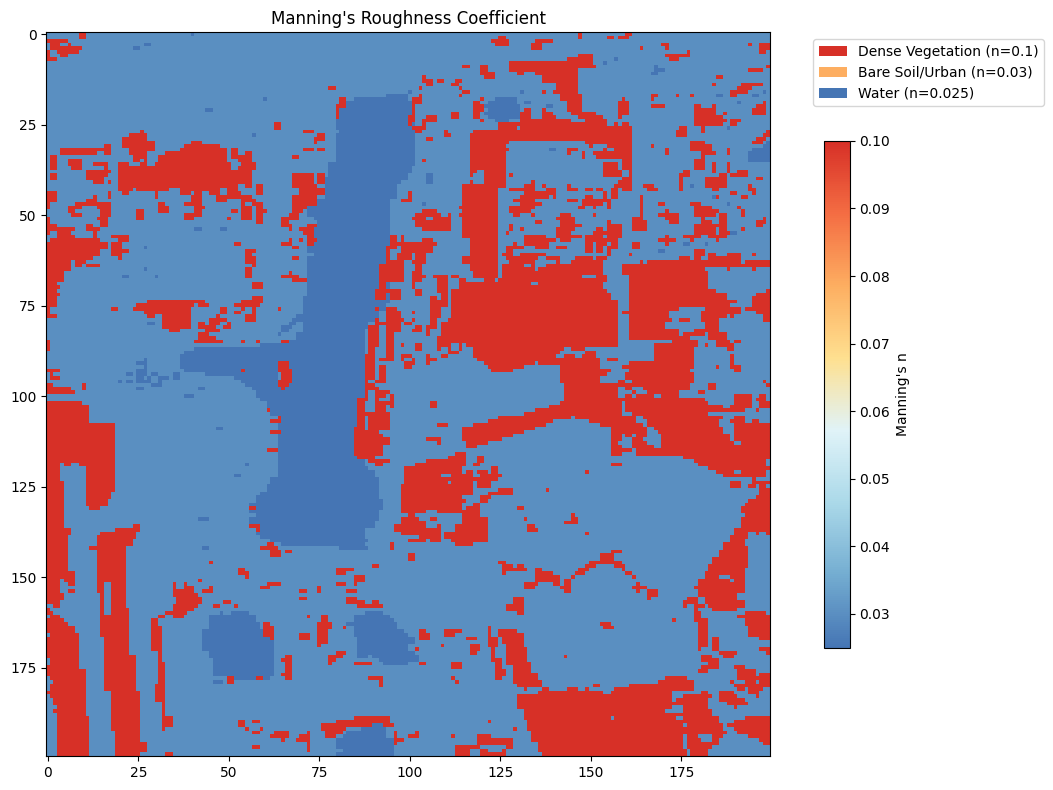


Manning's n Statistics:
--------------------------------------------------
Minimum n: 0.025
Maximum n: 0.100
Mean n: 0.048
--------------------------------------------------

Distribution of Manning's n values:
--------------------------------------------------
n value    Pixels     Percentage
--------------------------------------------------
0.025      3944             9.86%
0.030      25278           63.20%
0.100      10778           26.95%


In [43]:
manning_array = assign_mannings_n('scl_milano_clip.tif', 'manning_milano.tif')

plot = plot_mannings(manning_array)
plot.show()
print_manning_statistics(manning_array)


In [72]:
# Convert the Manning's n raster to a PFB file for ParFlow
from parflow.tools.io import write_pfb
from parflow.tools.io import write_dist
from parflow.tools.io import read_pfb

# Ensure the array is float64 (double precision)
manning_pfb = manning_array.astype(np.float64)

# Replace 0 values (no data) with a small Manning's n
# manning_pfb[manning_pfb == 0] = 1e-6

manning_block = np.zeros((200, 200))
manning_block = manning_pfb

write_pfb('manning.pfb', np.array(manning_block), p=1, q=1, r=1, x=0.0, y=0.0, z=0.0, dx=20.0, dy=20.0, dz=0.0, dist=0)
# write_dist('manning.dist', sg_offs=(0, 0, 0))


(1, 200, 200)


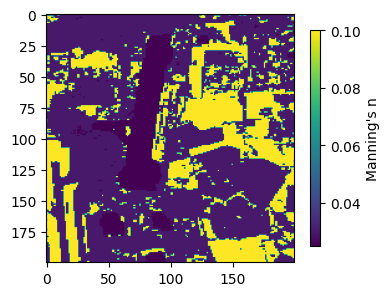

In [68]:

# Import the PFB file to check the data
manning_pfb = read_pfb('manning.pfb')
print(manning_pfb.shape)

# Plot the Manning's n PFB file
plt.figure(figsize=(4, 4))
img = plt.imshow(manning_pfb[0,:,:], cmap='viridis')
plt.colorbar(img, label="Manning's n", shrink=0.7)
